# 🥱 LangGraph - Intro 篇

在這個教程中，我們將深入探討 LangChain 和 LangGraph 的串流（Streaming）功能，這對於打造反應靈敏的 AI 應用至關重要。本指南假設您已熟悉以下概念：

- 聊天模型（Chat models）
- LangChain 表達語言（LangChain Expression Language）
- 輸出解析器（Output parsers）

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


# 環境建置

在開始我們的探索之前，讓我們先搭建實驗環境。

## 安裝套件包

在深入之前，我們需要先搭建實驗環境。

以下是所需的套件安裝命令：

In [3]:
%%capture --no-stderr
%pip install --quiet langchain
%pip install --quiet langchain-openai
%pip install --quiet langgraph

In [2]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

# 打造對話機器人

## 步驟 1：定義狀態

定義一個StateGraph物件以將聊天機器人建構成狀態機。 State是一個用 List 類型的單一鍵messages定義的類別對象List並使用add_messages()函數附加新訊息而不是覆寫它們。

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## 步驟 2：定義語言模型
在這裡，我們初始化 ChatOpenAI 模型並建立一個簡單的聊天機器人函數，該函數接受狀態訊息作為輸入並產生訊息回應（隨後附加到狀態）。

In [5]:
import os
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4-0613",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## 步驟 3：添加語言模型節點
此聊天機器人功能會作為名為「chatbot」的節點加入圖中

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

## 步驟 4：構建圖並且編譯
由於我們正在建立一個簡單的聊天機器人，因此我們將chatbot節點設定為圖表的入口點和結束點，以指示流程的開始和結束位置。

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

可以視覺化，查看圖的流向

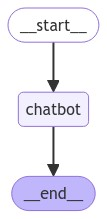

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 步驟 5：實現聊天界面

最後，我們實作一個循環來不斷提示使用者輸入，透過圖形處理，並列印助手的回應。當使用者輸入"quit" 、 "exit"或"q"時，循環退出。


In [12]:
while True:
    user_input = input("使用者: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("掰啦！")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("AI 助理:", value["messages"][-1].content)

使用者: 介紹一下高雄
AI 助理: 高雄市是台灣的第三大城市，位於台灣島的南部，是南台灣的最大都市和重要的海港城市。高雄市的面積約為2951.85平方公里，人口約為277萬人。

高雄市的歷史可以追溯到荷蘭統治時期，當時被稱為打狗。在日本統治時期，高雄成為重要的工業城市和海港。在二戰後，高雄繼續發展為台灣的重要工業中心和海港。

高雄市的地標包括85大樓（又稱「高雄天際塔」，是台灣第二高的摩天大樓）、愛河、西子灣、旗津、駁二藝術特區等。此外，高雄市也是台灣重要的文化中心，有許多博物館、藝術館和文化活動。

高雄市的經濟以重工業和港口運輸為主，包括鋼鐵、石化、造船、機械等產業。近年來，高雄市也積極發展觀光、服務業和高科技產業。

高雄市的交通非常便利，有高雄國際機場、高雄港、高鐵高雄站、台鐵新左營站等重要的交通樞紐。此外，高雄市也是台灣第一個擁有捷運系統的城市之一。

高雄市的氣候屬於熱帶季風氣候，全年溫暖，是一個適合旅遊的城市。
使用者: q
掰啦！
